In [16]:
import gym
from gym import spaces
import numpy as np
import torch
import pandas as pd
import ta

In [17]:

def normalize_state(state):
    # Zakładamy, że state to wektor [features]
    mean = np.mean(state, axis=0)
    std = np.std(state, axis=0) + 1e-8
    return (state - mean) / std

class TimeSeriesEnvOHLC_ls(gym.Env):
    def __init__(self, data, window_size=96, verbose= False):
        super(TimeSeriesEnvOHLC_ls, self).__init__()
        self.window_size = window_size
        self.verbose = verbose
        self.df = data.copy()
        
        # Wskaźniki techniczne
        self.df['SMA'] = ta.trend.sma_indicator(self.df['close'], window=14)
        self.df['EMA'] = ta.trend.ema_indicator(self.df['close'], window=14)
        self.df['RSI'] = ta.momentum.rsi(self.df['close'], window=14)
        self.df['MACD'] = ta.trend.macd_diff(self.df['close'])
        self.df['BB_upper'] = ta.volatility.bollinger_hband(self.df['close'])
        self.df['BB_lower'] = ta.volatility.bollinger_lband(self.df['close'])
        median_price = (self.df['high'] + self.df['low']) / 2
        self.df['MOM'] = median_price.rolling(window=5).mean() - median_price.rolling(window=34).mean()
        self.df.fillna(0.0, inplace=True)
        
        self.ohlc_data = self.df[['open', 'high', 'low', 'close']].values
        # self.ohlc_data = self.df[['open', 'high', 'low', 'close',
        #                           'SMA', 'EMA', 'RSI', 'MACD',
        #                           'BB_upper', 'BB_lower', 'MOM']].values

        self.current_step = window_size
        
        # Action space: 0=hold, 1=buy/long, 2=sell/short
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(
            low=0.0, high=1.0, 
            shape=(window_size, self.ohlc_data.shape[1]), 
            dtype=np.float32
        )
        
        self.min_val = np.min(self.ohlc_data, axis=0)
        self.max_val = np.max(self.ohlc_data, axis=0)
        
        self.initial_cash = 100_000.0
        self.cash = self.initial_cash
        self.long_inventory = []   # list of entry prices
        self.short_inventory = []  # list of entry prices
        self.total_profit = 0.0
        self.last_portfolio_value = self.initial_cash
        self.states_buy = []
        self.states_sell = []
        self.max_inventory = 1
    
    def reset(self):
        self.current_step = self.window_size
        self.cash = self.initial_cash
        self.long_inventory = []
        self.short_inventory = []
        self.total_profit = 0.0
        self.last_portfolio_value = self.initial_cash
        self.states_buy = []
        self.states_sell = []
        return self._get_observation()
    
    def _get_observation(self):
        window = self.ohlc_data[self.current_step - self.window_size:self.current_step]
        min_val = np.min(window, axis=0)
        max_val = np.max(window, axis=0)
        norm_window = normalize_state(window)
        #norm_window = (window - min_val) / (max_val - min_val + 1e-8)
        return np.clip(norm_window.astype(np.float32), -5, 5), [0 if len(self.long_inventory) > 0 else (1 if len(self.short_inventory) > 0 else 2)]
    
    
    def _portfolio_value(self, current_price):
        """Aktualna wartość portfela: gotówka + wartość pozycji."""
        return self.cash + self.position * (current_price - self.entry_price)

    def step(self, action):
        done = False
        price = self.ohlc_data[self.current_step][3]
        prev_price = self.ohlc_data[self.current_step - 1][3]

        action_name = ['HOLD', 'BUY', 'SELL'][action]

        # ==========================================
        # STORE STATE AT TIME t (BEFORE ACTION)
        # ==========================================
        balance_t = self.cash
        long_inventory_t = self.long_inventory.copy()
        short_inventory_t = self.short_inventory.copy()

        # Portfolio value at time t
        portfolio_value_t = self.cash
        for long_entry in self.long_inventory:
            portfolio_value_t += (prev_price - long_entry)
        for short_entry in self.short_inventory:
            portfolio_value_t += (short_entry - prev_price)

        # ==========================================
        # EXECUTE ACTION
        # ==========================================
        transaction_value = 0.0  # For calculating commission
        profit = 0.0
        if action == 1:  # BUY / LONG
            if len(self.short_inventory) > 0:
                # Close short position
                #print('BUY',self.short_inventory, self.long_inventory)
                short_entry = self.short_inventory.pop(0)
                profit = short_entry - price
                self.cash += profit
                self.total_profit += profit
                transaction_value = price  # Transaction value for commission
                self.states_buy.append(self.current_step)
            else:
                # Open long position
                if len(self.short_inventory) + len(self.long_inventory) < self.max_inventory:
                    #print('LONG',self.short_inventory, self.long_inventory)
                    self.long_inventory.append(price)
                    self.states_buy.append(self.current_step)
                    transaction_value = price

        elif action == 2:  # SELL / SHORT
            if len(self.long_inventory) > 0:
                # Close long position
                #print('SELL',self.short_inventory, self.long_inventory)
                long_entry = self.long_inventory.pop(0)
                profit = price - long_entry
                self.cash += profit
                self.total_profit += profit
                transaction_value = price
                self.states_sell.append(self.current_step)
            else:
                # Open short position
                if len(self.short_inventory) + len(self.long_inventory) < self.max_inventory:
                    #print('SHORT',self.short_inventory, self.long_inventory)
                    self.short_inventory.append(price)
                    self.states_sell.append(self.current_step)
                    transaction_value = price

        # ==========================================
        # CALCULATE PORTFOLIO VALUE AT TIME t+1 (AFTER ACTION)
        # ==========================================
        returns = []
        portfolio_value_t1 = self.cash
        for long_entry in self.long_inventory:
            returns.append(price - long_entry)
            portfolio_value_t1 += (price - long_entry)
        for short_entry in self.short_inventory:
            returns.append(short_entry - price)
            portfolio_value_t1 += (short_entry - price)

        # ==========================================
        # CALCULATE REWARD (PAPER'S EQUATION 4)
        # ==========================================
        commission_rate = 0.001  # 0.1%
        transaction_cost = transaction_value * commission_rate

        # Reward = change in portfolio value - transaction cost
        #reward = portfolio_value_t1 - portfolio_value_t
        
        self.last_portfolio_value = portfolio_value_t1
        self.current_step += 1

        reward = profit#np.clip(profit, -1, 1)

        #reward = profit
        sharpe = (np.mean(returns) / (np.std(returns) + 1e8)) if returns else 0
        value_reward = (portfolio_value_t1 - portfolio_value_t)# / portfolio_value_t
        reward =  value_reward #(value_reward + profit + sharpe ) / 3  #/ portfolio_value_t
        #reward =  (portfolio_value_t1 - portfolio_value_t) / portfolio_value_t
        #reward = np.tanh(reward * 100) 
        # ==========================================
        # DONE CONDITION
        # ==========================================
        if self.current_step >= len(self.ohlc_data):
            done = True
            final_price = self.ohlc_data[-1][3]

            # Close all positions
            for long_entry in self.long_inventory:
                profit = final_price - long_entry
                self.cash += profit
                self.total_profit += profit

            for short_entry in self.short_inventory:
                profit = short_entry - final_price
                self.cash += profit
                self.total_profit += profit

            if self.verbose:
                print(f"{'='*110}")
                print(f"DONE | Final Portfolio: {self.cash:12.2f} | "
                    f"Total P/L: {self.total_profit:+10.2f} | "
                    f"Total Trades: {len(self.states_buy) + len(self.states_sell)}")
                print(f"{'='*110}")

        # ==========================================
        # LOG
        # ==========================================
        if self.verbose and self.current_step % 222 == 0:
            print(f"Step: {self.current_step:4d} | Action: {action_name:4s} | "
                f"Price: {price:8.2f} | Reward: {reward:+8.6f} | "
                f"Longs: {len(self.long_inventory):2d} | Shorts: {len(self.short_inventory):2d} | "
                f"Portfolio Value: {portfolio_value_t1:12.2f}")

        return self._get_observation(), float(reward), done

         open        high         low       close  volume
0  100.000000  100.407106   99.331123  100.000000     917
1  100.000000  101.319342   99.201344  101.253332     909
2  101.253332  102.835719  100.320579  102.486899     991
3  102.486899  103.792244  102.466761  103.681246     910
4  103.681246  105.625772  103.527462  104.817537     996


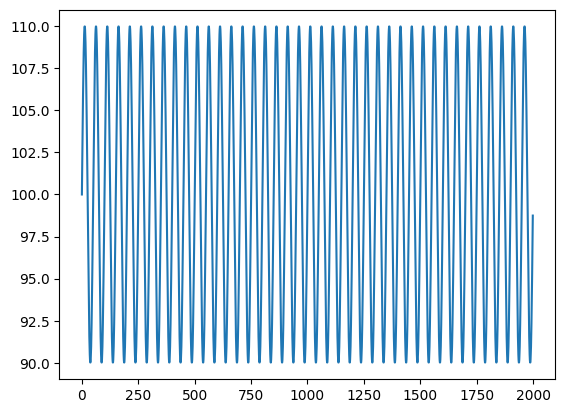

In [18]:
import numpy as np
import pandas as pd

def generate_sine_ohlc(n_steps=500, amplitude=10, base_price=100, noise_std=0.0, seed=42):
    np.random.seed(seed)
    t = np.arange(n_steps)
    
    # Close = sinus + szum
    close = base_price + amplitude * np.sin(2 * np.pi * t / 50) + np.random.normal(0, noise_std, n_steps)
    
    # Open = poprzednie close
    open_ = np.roll(close, 1)
    open_[0] = close[0]
    
    # High / Low = +/- losowy drobny zakres
    high = np.maximum(open_, close) + np.random.uniform(0, 1, n_steps)
    low = np.minimum(open_, close) - np.random.uniform(0, 1, n_steps)
    
    # Volume (opcjonalnie)
    volume = np.random.randint(900, 1000, n_steps)
    
    ohlc = pd.DataFrame({
        'open': open_,
        'high': high,
        'low': low,
        'close': close,
        'volume': volume
    })
    
    return ohlc

# Przykład
df = generate_sine_ohlc(n_steps=2000)
print(df.head())
import matplotlib.pyplot as plt
plt.plot(df['close'])


In [32]:

df = pd.read_csv('data/EURUSD_M15.csv')

# Rename columns
df.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)

# Keep only desired columns
df = df[['open', 'high', 'low', 'close', 'volume']]
df.shape

(512627, 5)

In [33]:
df = df.iloc[-5_000:]
df.shape

(5000, 5)

In [34]:
# from utils.database import read_stock_data

# df = read_stock_data('NVDA')[0]
# df = df[['open', 'high', 'low', 'close', 'volume']]

In [35]:
from agents.rainbowDQN import RainbowAgent


In [36]:
# Długość całego zbioru

n = len(df)

# Proporcje
train_end = int(0.8 * n)

# Podziały
train_df = df.iloc[:train_end]
valid_df = df.iloc[train_end:]

valid_smaler_xd = valid_df.iloc[-10_000:] 

# env = TimeSeriesEnv_simple(train_df, 96)
# valid_env = TimeSeriesEnv_simple(valid_df, 96)
env = TimeSeriesEnvOHLC_ls(train_df, 256)
valid_env = TimeSeriesEnvOHLC_ls(valid_df, 256)

all_evd = TimeSeriesEnvOHLC_ls(df, 256)
valid_smaler_xd = TimeSeriesEnvOHLC_ls(valid_smaler_xd, 256)

env.reset()

(array([[-0.18178467, -0.28190967, -0.16930167, -0.28009248],
        [-0.29247048, -0.37652528, -0.191392  , -0.28650948],
        [-0.29898143, -0.40262613, -0.25135148, -0.36993062],
        ...,
        [-2.4150338 , -2.4678566 , -2.416204  , -2.5709653 ],
        [-2.6136172 , -2.7158146 , -2.5550573 , -2.6736374 ],
        [-2.7112813 , -2.7875922 , -2.5550573 , -2.6351354 ]],
       dtype=float32),
 [2])

In [37]:
agent = RainbowAgent('sine')

In [38]:
def test_dqn_agent(env, agent, device="cuda:0", plot=True):
    """
    Testuje agenta DQN (lub Rainbow DQN) w środowisku OHLC
    i wizualizuje działania agenta.
    """
    state,porfolio = env.reset()
    done = False
    total_reward = 0
    steps = 0

    # Wyzeruj stany kupna/sprzedaży
    env.states_buy = []
    env.states_sell = []

    while not done:
        # --- przygotowanie stanu ---
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        # --- wybór akcji ---
        with torch.no_grad():
            porfolio = torch.FloatTensor(np.array(porfolio)).to('cuda')
            q_values = agent.model(state_tensor,porfolio)
            action = torch.argmax(q_values, dim=1).item()  # 0=hold,1=long,2=short

        # --- wykonanie kroku w środowisku ---
        (next_state, porfolio), reward, done = env.step(action)

        total_reward += reward
        steps += 1
        state = next_state

    prices = env.ohlc_data[:, 3]  # kolumna 'close'
    buy_points = [i for i in env.states_buy if i < len(prices)]
    sell_points = [i for i in env.states_sell if i < len(prices)]
    profit = env.total_profit

    if plot:
        print(f"Łączny reward: {profit:.2f} | Liczba kroków: {steps}")

        # --- wizualizacja ---
        plt.figure(figsize=(14, 6))
        plt.plot(prices, label='Cena', linewidth=1.5)

        if buy_points:
            plt.scatter(buy_points, [prices[i] for i in buy_points],
                        color='green', marker='^', label='Kup', s=100)
        if sell_points:
            plt.scatter(sell_points, [prices[i] for i in sell_points],
                        color='red', marker='v', label='Sprzedaj', s=100)

        plt.title(f'Działania agenta DQN | Łączny zysk: {profit:.2f}')
        plt.axvline(x=env.window_size, color='red', linestyle='--', label='Początek okna')
        plt.xlabel('Krok')
        plt.ylabel('Cena')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return profit


In [39]:
from tqdm import tqdm
import numpy as np
import torch

# Parametry treningu
num_episodes = 5
epsilon_start = 0.9
epsilon_end = 0.2
epsilon_decay = 0.995
epsilon_decay = (epsilon_start - epsilon_end) / num_episodes

agent.model.train()
episode_rewards = []

epsilon = epsilon_start
rewards = []
for episode in tqdm(range(num_episodes), desc="Training Rainbow DQN"):
    state, porfolio = env.reset()
    done = False
    total_reward = 0
    step = 0

    while not done:
        step += 1
        
        # Eksploracja tylko jeśli nie używamy NoisyNets
        if np.random.random() < epsilon:
            action = np.random.randint(agent.action_space)
        else:
            porfolio = torch.FloatTensor(np.array(porfolio)).to('cuda')
            action = agent.get_action(state, porfolio)

        (next_state, porfolio), reward, done = env.step(action)

        total_reward += reward

        # Zapis doświadczenia
        agent.update_replay_memory((state,porfolio, action, reward, next_state, done))
        state = next_state

        # Trening agenta
        agent.train()

    reward = test_dqn_agent(valid_env, agent, plot=False)
    print(f"Epizod {episode + 1}: Łączny reward: {reward:.2f}")
    # Zmniejszanie epsilon (jeśli nie używasz NoisyNet)
    epsilon = max(epsilon_end, epsilon - epsilon_decay)
    rewards.append(reward)
    episode_rewards.append(total_reward)

    # Ewaluacja co pewien czas
    if (episode + 1) % 10 == 0:
        avg_reward = np.mean(episode_rewards[-10:])
        print(f"Epizod {episode + 1} | Śr. nagroda: {avg_reward:.2f} | Epsilon: {epsilon:.3f}")
        agent.save()


Training Rainbow DQN:  20%|██        | 1/5 [00:58<03:52, 58.20s/it]

Epizod 1: Łączny reward: -0.00


Training Rainbow DQN:  40%|████      | 2/5 [01:53<02:49, 56.41s/it]

Epizod 2: Łączny reward: -0.00


Training Rainbow DQN:  60%|██████    | 3/5 [02:50<01:53, 56.64s/it]

Epizod 3: Łączny reward: -0.01


Training Rainbow DQN:  80%|████████  | 4/5 [03:42<00:54, 54.90s/it]

Epizod 4: Łączny reward: 0.01


Training Rainbow DQN: 100%|██████████| 5/5 [04:36<00:00, 55.32s/it]

Epizod 5: Łączny reward: -0.00


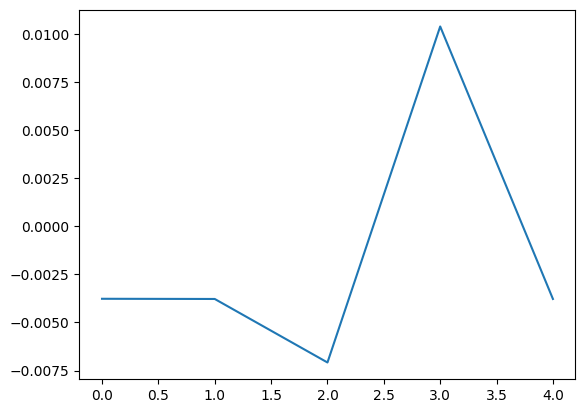

In [40]:
import matplotlib.pyplot as plt
plt.plot(rewards)

Łączny reward: -0.00 | Liczba kroków: 744


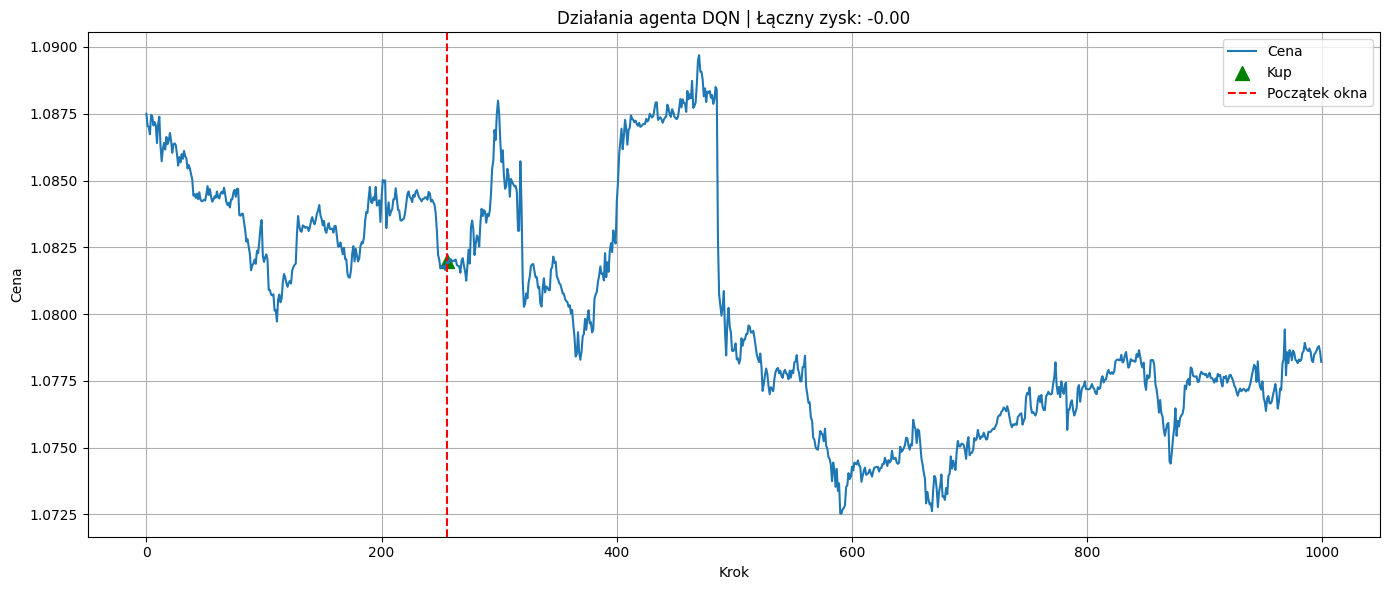

-0.0037800000000001166

In [41]:
test_dqn_agent(valid_smaler_xd, agent)

Łączny reward: -0.00 | Liczba kroków: 3744


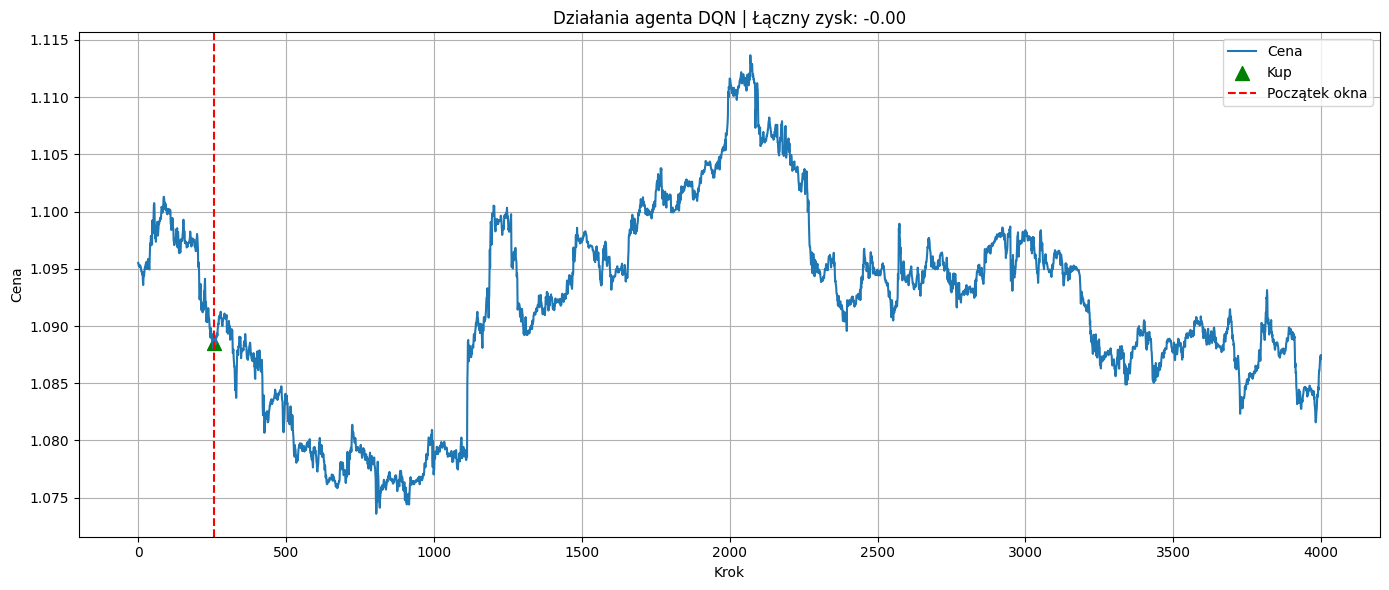

-0.0010399999999999299

In [42]:
test_dqn_agent(env, agent)

In [ ]:

test_dqn_agent(all_evd, agent)